In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
Poore_BLCA = pd.read_csv("Poore_BLCA", index_col=0)
Poore_BLCA

,f__Halomonadaceae; g__Cobetia,f__Thermoanaerobacteraceae; g__Ammonifex,f__Cryomorphaceae; g__Owenweeksia,f__Haloplasmataceae; g__Haloplasma,f__Desulfobacteraceae; g__Desulfosarcina,f__Enterobacteriaceae; g__Siccibacter,f__Acetobacteraceae; g__Asaia,f__Rhodobiaceae; g__Parvibaculum,g__Neosynechococcus,f__Sphingomonadaceae; g__Zymomonas,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s2803,1.920406,2.672018,2.367002,0.940031,1.232461,2.305885,2.002862,1.850657,2.367745,0.100389,...,30.0,0.17,1.90,30.43,RNA,NaN,NaN,NaN,2013.0,Alive
s2818,0.575837,2.554444,2.291717,2.598751,1.194319,2.087722,2.225309,0.947783,2.423590,-0.478696,...,30.0,0.17,1.88,57.79,RNA,NaN,NaN,NaN,2012.0,Dead
s2739,2.371029,3.318483,2.886261,2.828579,1.511368,2.960159,2.651312,2.581111,2.998545,1.055463,...,2.0,0.17,NaN,40.03,DNA,NaN,NaN,NaN,2011.0,Alive
s2683,-1.297436,3.088465,2.418900,-0.167309,1.477646,2.754875,2.265682,1.883929,2.571443,-0.302522,...,20.0,0.08,NaN,55.07,DNA,8ABD32E6-50C9-44EB-BA59-4572AA05C26C,Primary Tumor Field,External,2011.0,Alive
s2740,2.101283,3.048737,2.616515,1.821867,1.013353,2.690412,2.381566,2.311365,2.728799,0.785717,...,2.0,0.15,NaN,37.23,DNA,NaN,NaN,NaN,2011.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s3399,1.629153,2.532004,2.086196,0.768015,1.767636,2.065759,1.810276,3.350909,2.171045,-0.087753,...,30.0,0.18,1.86,86.39,RNA,NaN,NaN,NaN,2013.0,Alive
s3397,1.659999,2.644176,2.185795,0.942269,1.843089,2.282400,1.726946,1.860152,2.282646,0.028421,...,30.0,0.17,1.83,21.29,RNA,NaN,NaN,NaN,2011.0,Alive
s3402,2.391737,3.294074,2.869479,1.585118,0.715287,2.944666,2.446944,2.530973,3.036099,2.690550,...,30.0,0.17,1.89,42.53,RNA,NaN,NaN,NaN,2007.0,Dead


In [3]:
class_counts = Poore_BLCA['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           557
Blood Derived Normal    124
Solid Tissue Normal      48
Name: count, dtype: int64


In [4]:
# Prepare features and target variable
X = Poore_BLCA.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
y = Poore_BLCA['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Primary Tumor' 'Solid Tissue Normal']
Unique values of y: [0 1 2]


In [5]:
# Oversampling to ensure class balance
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(1671, 1273)
(1671,)


In [6]:
# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

random_seed = 42
lsvc = LinearSVC(C = 0.01, penalty="l1", dual=False).fit(X_scaled, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_scaled)

X_new.shape

(1671, 285)

Best Parameters: {'alpha': 0.1, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score: 0.9298521697663327
Test Set Accuracy: 0.954183266932271


<Figure size 800x600 with 0 Axes>

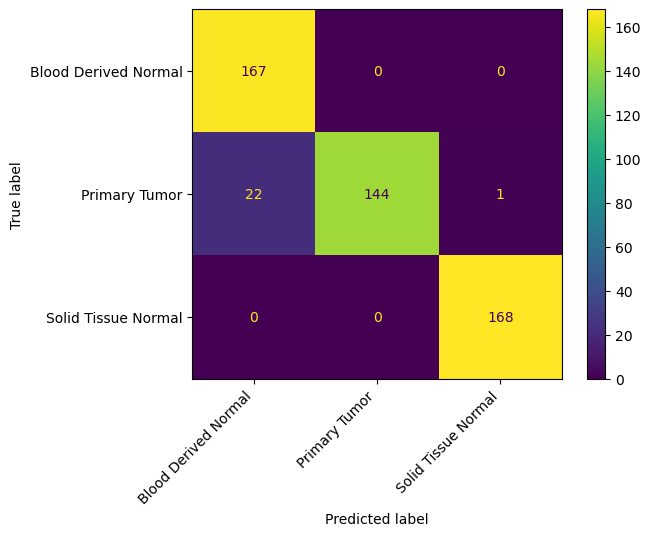

In [12]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

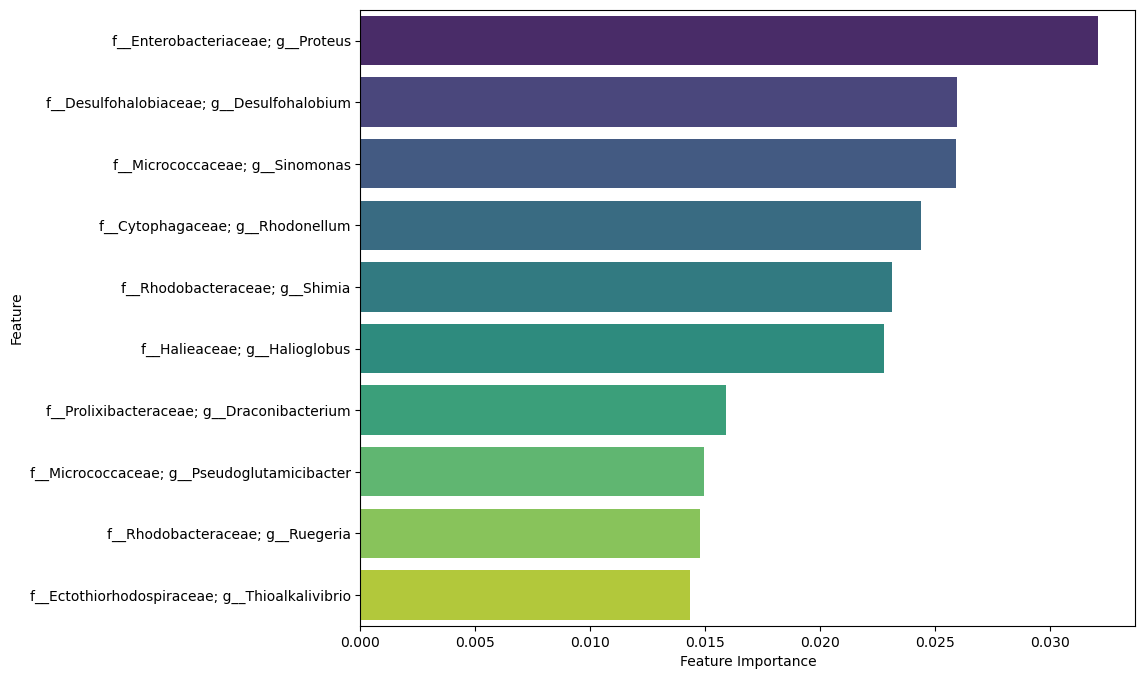

In [13]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_10_indices = feature_importances.argsort()[::-1][:10]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_10_indices], y=feature_names[top_10_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

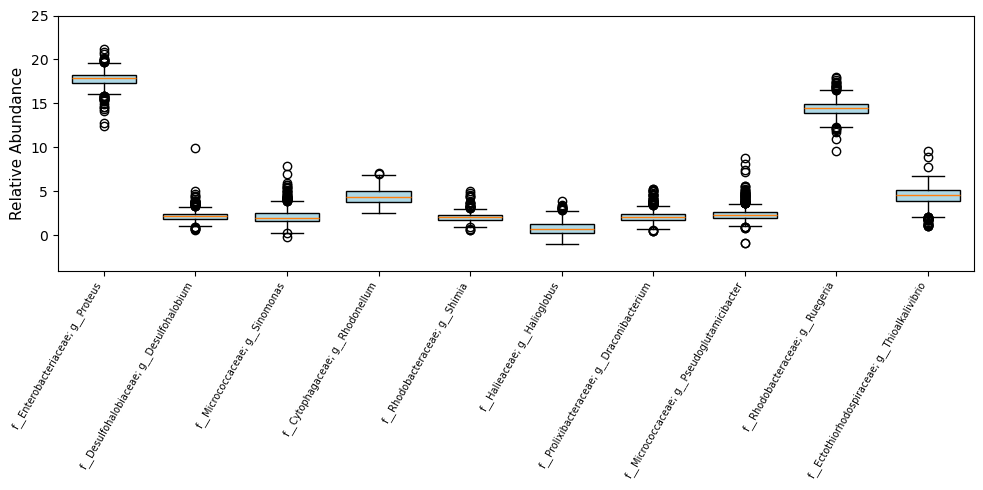

In [14]:
# Box plot for visualizing bacterial relative abundance of 10 most important bacteria

data = {}
top_20_feature_names = feature_names[top_10_indices]
#abundance_scaled = np.log2(X)

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(-4, 25)
plt.ylabel('Relative Abundance', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=7)
plt.tight_layout()  
plt.show()